### 목표

- CNN 개념 이해 및 실습
- 전이학습 이해 및 실습

In [16]:
import os # 폴더정보 획득을 위한 라이브러리
import shutil # 파일 이동을 위한 라이브러리
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 반복문 작업의 진척률을 알려주는 도구
from tensorflow.keras.utils import image_dataset_from_directory # 폴더로부터 이미지를 로딩하는 함수
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten
from tensorflow.keras.layers import Conv2D # 특징을 강조하는 레이어(학습기반)
from tensorflow.keras.layers import MaxPooling2D # 불필요한 부분을 삭제하는 레이어
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import evaluate

ImportError: ignored

In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/Ai_Deep_Learning/data"

/content/drive/MyDrive/Colab Notebooks/Ai_Deep_Learning/data


In [ ]:
# 코랩내부에서 데이터 다운로드
!git clone https://github.com/yellow-ai/test111111111111111.git


In [ ]:
# 압축 풀기
!unzip ./animal10/archive.zip -d ./animal10/

In [ ]:
# 첫번째 동물
# 폴더경로 설정
path1 = "./animal10/raw-img/scoiattolo"
# 사진이름 목록 만들기
img_list1 = os.listdir(path1)
# 갯수 확인
len(img_list1)

In [ ]:
# 첫번째 동물
# 폴더경로 설정
path2 = "./animal10/raw-img/cane"
# 사진이름 목록 만들기
img_list2 = os.listdir(path2)
# 갯수 확인
len(img_list2)

In [ ]:
# 랜덤하게 1800장 선택
img_list1_1800 = np.random.choice(img_list1,1800, replace=False)
img_list2_1800 = np.random.choice(img_list2,1800, replace=False)

In [ ]:
# 이동시킬 폴더 생성
!mkdir ./animal10/sample
!mkdir ./animal10/sample/scoiattolo
!mkdir ./animal10/sample/cane

In [ ]:
# 사진이동
for file_name in img_list1_1800:
  shutil.move(os.path.join(path1,file_name), # origin path
              os.path.join("./animal10/sample/scoiattolo",file_name)) # dest path

In [ ]:
# 사진이동
for file_name in img_list2_1800:
  shutil.move(os.path.join(path2,file_name), # origin path
              os.path.join("./animal10/sample/cane",file_name)) # dest path

### 사진데이터 로딩

In [ ]:
train_data = image_dataset_from_directory(
    directory = "./animal10/sample", # 읽어들일 폴더
    labels = "inferred", # 폴더명을 인식해서 사진마다 정답으로 붙여 줌
    label_mode = 'binary', # 다중분류 형태로 정답이 생성
    color_mode = 'rgb', # 컬러사진 설정
    image_size = (224 ,224) # 읽어들인 사진의 크기 crop

)

In [ ]:
X_train = [] # 읽어들인 사진데이터가 저장될 리스트
y_train = [] # 읽어들인 정답데이터가 저장될 리스트

In [ ]:
# 32장씩 문제와 정답 로딩
for img, label in tqdm(train_data.as_numpy_iterator()): #tqdm -> 반복된 횟수를 알수있다.
  X_train.append(img)
  y_train.append(label)

In [ ]:
# 리스트에 담겨있는 사진데이터 및 정답데이터를 하나의 넘파이로 통합
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
print(X_train.shape, y_train.shape)

In [ ]:
# 60% 훈련데이터 저장
np.savez("./animal10/animal_numpy_X_small.npz", X=X_train)
np.savez("./animal10/animal_numpt_y_small.npz", y=y_train)

### 1.MLP 모델링
- 손글씨 학습코드 참고
- 이진 분류
- 입력층과 출력층 고민
- 모델자동저장 및 조기학습중단 적용

In [4]:
# 전체 데이터 로딩
X_file= np.load("./animal10/animal_numpy_X_small.npz")
y_file= np.load("./animal10/animal_numpy_y_small.npz")

# 시스템 RAM 메모리에 적재
X_train = X_file['X']
y_train = y_file['y']

In [5]:
# stratify -> 훈련/ 평가 데이터에 들어가는 카테고의 비율을 비슷하게 유지해주는 속성
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                            y_train,
                                                            test_size = 0.2,
                                                            random_state= 926,
                                                            )


(2880, 224, 224, 3) (2880, 2)
(720, 224, 224, 3) (720, 2)


In [6]:
y_train_one_hot = to_categorical(y_train_L)
y_test_one_hot = to_categorical(y_test_L)

In [9]:
print(X_train_L.shape,y_train_one_hot.shape)
print(X_test_L.shape, y_test_one_hot.shape)

(2880, 224, 224, 3) (2880, 2)
(720, 224, 224, 3) (720, 2)


In [10]:
# 1. 모델 구조 설계
mlp_model = Sequential()

mlp_model.add( InputLayer (input_shape = (224,224,3)))
mlp_model.add( Flatten()) # 입력된 데이터를 1차원으로 평평하게 만들어주는 층
mlp_model.add( Dense(units= 512, activation = 'relu') ) # 중간층(은닉층)
mlp_model.add( Dense(units= 256, activation = 'relu') )
mlp_model.add( Dense(units= 128, activation = 'relu') )

mlp_model.add( Dense(units= 2, activation = 'sigmoid') ) # 출력층
# 다중분류 출력층의 units= 클래스 수, 활성화함수 = 'softmax'

# 2. 모델 학습/ 평가 방법 설정
mlp_model.compile( loss = "binary_crossentropy",
                    optimizer = Adam(),
                     metrics = ['accuracy']
                     )

In [12]:
early = EarlyStopping(monitor="val_accuracy", patience=5)

# 모델자동 저장

model_path = "./animal10/animal_binary-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mdkpt = ModelCheckpoint(filepath=model_path,
                        save_best_only=True,
                        monitor="val_accuracy")

In [13]:
mlp_history = mlp_model.fit(X_train_L, y_train_one_hot,
                            validation_split = 0.2,
                            callbacks=[early,mdkpt],
                            epochs =100)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 2448.2358 - accuracy: 0.5668

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 18s 158ms/step - loss: 2448.2358 - accuracy: 0.5668 - val_loss: 250.1308 - val_accuracy: 0.6962
Epoch 2/100
72/72 [==============================] - 7s 105ms/step - loss: 427.6056 - accuracy: 0.6267 - val_loss: 152.7398 - val_accuracy: 0.7066
Epoch 3/100
72/72 [==============================] - 3s 39ms/step - loss: 153.6433 - accuracy: 0.6953 - val_loss: 256.6734 - val_accuracy: 0.5694
Epoch 4/100
72/72 [==============================] - 4s 56ms/step - loss: 173.8802 - accuracy: 0.6771 - val_loss: 123.5277 - val_accuracy: 0.6927
Epoch 5/100
72/72 [==============================] - 3s 48ms/step - loss: 104.3837 - accuracy: 0.7075 - val_loss: 46.7957 - val_accuracy: 0.6979
Epoch 6/100
72/72 [==============================] - 3s 42ms/step - loss: 58.0606 - accuracy: 0.7166 - val_loss: 88.7632 - val_accuracy: 0.5712
Epoch 7/100
72/72 [==============================] - 3s 39ms/step - loss: 50.5846 - accuracy: 0.7079 - val_loss: 75.3101 - val_accuracy

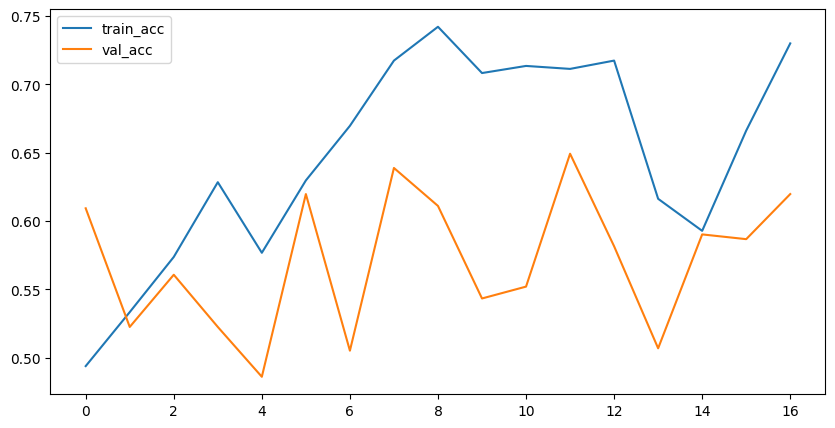

In [ ]:
# 결과시각화
plt.figure(figsize=(10,5)) # 가로, 세로
plt.plot(mlp_history.history['accuracy'], label='train_acc')
plt.plot(mlp_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

### 2.CNN 모델링

In [19]:
# 1. 모델 구조
cnn_model = Sequential()
# 입력층
cnn_model.add( InputLayer (input_shape = (224,224,3)))
# 특성추출 레이어
cnn_model.add(Conv2D(filters=128,   #특징을 추출하는 돋보기 갯수
                     kernel_size=(5,5), # 돋보기(이미지커널)의 크기
                     activation="relu"
                     ))
cnn_model.add(MaxPooling2D()) # conv가 강조한 픽셀정보를 제외하고 나머지를 제거
cnn_model.add(Conv2D(filters=256,   #특징을 추출하는 돋보기 갯수
                     kernel_size=(5,5), # 돋보기(이미지커널)의 크기
                     activation="relu"
                     ))
cnn_model.add(MaxPooling2D()) # conv가 강조한 픽셀정보를 제외하고 나머지를 제거


cnn_model.add( Flatten()) # 입력된 데이터를 1차원으로 평평하게 만들어주는 층
# 중간층(은닉층)
cnn_model.add( Dense(units= 128, activation = 'relu') )
cnn_model.add( Dense(units= 64, activation = 'relu') )

cnn_model.add( Dense(units= 2, activation = 'sigmoid') ) # 출력층
# 다중분류 출력층의 units= 클래스 수, 활성화함수 = 'softmax'

# 2. 모델 학습/ 평가 방법 설정
cnn_model.compile( loss = "binary_crossentropy",
                    optimizer = Adam(),
                     metrics = ['accuracy']
                     )

In [20]:
early = EarlyStopping(monitor="val_accuracy", patience=5)

# 모델자동 저장

model_path = "./animal10/animal_cnn-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mdkpt = ModelCheckpoint(filepath=model_path,
                        save_best_only=True,
                        monitor="val_accuracy")

In [22]:
cnn_history = cnn_model.fit(X_train_L, y_train_one_hot,
                            validation_split = 0.2,
                            callbacks=[early,mdkpt],
                            epochs =100)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 87.7330 - accuracy: 0.5326

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 40s 359ms/step - loss: 87.7330 - accuracy: 0.5326 - val_loss: 0.6969 - val_accuracy: 0.4983
Epoch 2/100
72/72 [==============================] - 35s 490ms/step - loss: 0.6839 - accuracy: 0.5677 - val_loss: 0.7238 - val_accuracy: 0.5694
Epoch 3/100
72/72 [==============================] - 14s 194ms/step - loss: 0.6230 - accuracy: 0.6567 - val_loss: 0.6957 - val_accuracy: 0.5660
Epoch 4/100
72/72 [==============================] - 59s 831ms/step - loss: 0.4612 - accuracy: 0.7717 - val_loss: 0.9836 - val_accuracy: 0.6250
Epoch 5/100
72/72 [==============================] - 14s 190ms/step - loss: 0.3678 - accuracy: 0.8281 - val_loss: 1.5657 - val_accuracy: 0.5851
Epoch 6/100
72/72 [==============================] - 14s 196ms/step - loss: 0.2719 - accuracy: 0.8863 - val_loss: 1.4372 - val_accuracy: 0.5972
Epoch 7/100
72/72 [==============================] - 14s 197ms/step - loss: 0.1981 - accuracy: 0.9188 - val_loss: 1.9197 - val_accuracy: 0.6163
Epo

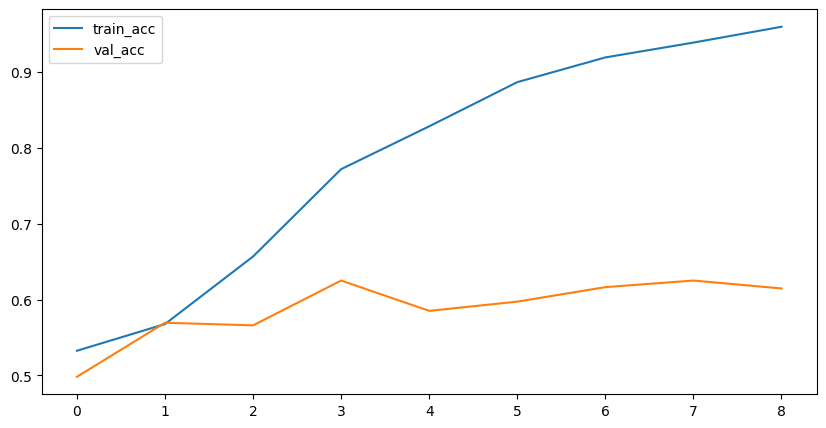

In [24]:
# 결과시각화
plt.figure(figsize=(10,5)) # 가로, 세로
plt.plot(cnn_history.history['accuracy'], label='train_acc')
plt.plot(cnn_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

### 3. 전이학습

In [3]:
vgg16 = VGG16(include_top=False, # MLP층을 제외하고 가져오겠다.
              weights='imagenet', # 학습된 가중치 상태로 불러오겠다.
              input_shape=(224,224,3))

In [7]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
my_vgg_model = Sequential()
my_vgg_model.add(vgg16)
my_vgg_model.add(Flatten())
my_vgg_model.add(Dense(64,activation='relu'))
# 출력층
my_vgg_model.add(Dense(2,activation="sigmoid"))



# 2. 모델 학습/ 평가 방법 설정
my_vgg_model.compile( loss = "binary_crossentropy",
                    optimizer = Adam(),
                     metrics = ['accuracy']
                     )

In [13]:
early = EarlyStopping(monitor="val_accuracy", patience=5)

# 모델자동 저장

model_path = "./animal10/animal_vgg-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mdkpt = ModelCheckpoint(filepath=model_path,
                        save_best_only=True,
                        monitor="val_accuracy")

In [14]:
# vgg16 전처리 실행
X_train = preprocess_input(X_train)

In [15]:
my_vgg_history = my_vgg_model.fit(X_train_L, y_train_one_hot,
                            validation_split = 0.2,
                            callbacks=[early,mdkpt],
                            epochs =100)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 1.5528 - accuracy: 0.5347

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 73s 631ms/step - loss: 1.5528 - accuracy: 0.5347 - val_loss: 0.6966 - val_accuracy: 0.5052
Epoch 2/100
72/72 [==============================] - 42s 578ms/step - loss: 0.6369 - accuracy: 0.6558 - val_loss: 0.6331 - val_accuracy: 0.6701
Epoch 3/100
72/72 [==============================] - 46s 647ms/step - loss: 0.5897 - accuracy: 0.7014 - val_loss: 0.6047 - val_accuracy: 0.6910
Epoch 4/100
72/72 [==============================] - 31s 436ms/step - loss: 0.5442 - accuracy: 0.7357 - val_loss: 0.6622 - val_accuracy: 0.6684
Epoch 5/100
72/72 [==============================] - 46s 644ms/step - loss: 0.5210 - accuracy: 0.7513 - val_loss: 0.5416 - val_accuracy: 0.7222
Epoch 6/100
72/72 [==============================] - 31s 435ms/step - loss: 0.6915 - accuracy: 0.6393 - val_loss: 0.5904 - val_accuracy: 0.7118
Epoch 7/100
72/72 [==============================] - 32s 443ms/step - loss: 0.5338 - accuracy: 0.7483 - val_loss: 0.5727 - val_accuracy: 0.7188
Epoc

In [ ]:
# best 모델 로딩
best_vgg_model = load_model('./animal10/ ')

In [ ]:
X_test = preprocess_input(X_test)

In [ ]:
best_vgg_model.evaluate(X_test,)